## Загрузка данных

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ismirnov56","key":"4443d5196fd2eebbc7b62bc8b480d636"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 94% 212M/225M [00:03<00:00, 99.8MB/s]
100% 225M/225M [00:03<00:00, 77.1MB/s]


In [7]:
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  i

In [8]:
root_data_path = 'flowers/'

In [9]:
import os

CLASSES = os.listdir(root_data_path)

In [10]:
FILES_MAPPING = {
    'sunflower': 'подсолнух',
    'dandelion': 'одуванчик',
    'daisy': 'маргаритка', 
    'tulip': 'тюльпан',
    'rose': 'роза'
}

In [11]:
from PIL import Image
import numpy
import cv2
IMAGE_DIM = 150, 150


train = []  

for i in CLASSES:
    path = os.path.join(root_data_path, i)
    idx = CLASSES.index(i)
    for img_name in os.listdir(path):
        if img_name.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, IMAGE_DIM)
            train.append([img_array, idx])

In [12]:
X=[] #Training images
y=[] #labels
for i,j in train:
    X.append(i)
    y.append(j)

In [13]:
del train

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from keras import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Activation, Dense
import numpy as np

In [17]:
X = np.array(X).reshape(-1,*IMAGE_DIM,3)/255.0

y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3453, 150, 150, 3), (3453, 5), (864, 150, 150, 3), (864, 5))

In [18]:
EPOCHS = 20
BATCH_SIZE = 128
NUM_TRAINING_IMAGES = x_train.shape[0]
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [22]:
def start_learn_cnn(obj):
    print(obj.summary())
    obj.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
    history = obj.fit(x_train, y_train, epochs=EPOCHS, verbose = 1, validation_data = (x_test,y_test), steps_per_epoch = STEPS_PER_EPOCH).history
    print(history)
    results = obj.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
    print("Validation loss, accuracy:", results)
    return history

In [23]:
cnn_histories = []

In [24]:
cnn = Sequential([
      Conv2D(32, (3, 3), input_shape=(*IMAGE_DIM, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      
      Conv2D(64, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      
      Flatten(),
      Dense(128, activation="relu"),
      Dense(5, activation="softmax")
  ])
cnn_histories.append(start_learn_cnn(cnn))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_3 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                  

In [25]:
cnn = Sequential([
      Conv2D(32, (3, 3), input_shape=(*IMAGE_DIM, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(64, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Flatten(),
      Dense(128, activation="relu"),
      Dropout(0.2),
      Dense(5, activation="softmax")
  ])
cnn_histories.append(start_learn_cnn(cnn))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 72, 72, 64)        0         
                                                      

In [27]:
cnn = Sequential([
      Conv2D(64, (3, 3), input_shape=(*IMAGE_DIM, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),

      Conv2D(256, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),

      Conv2D(256, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Flatten(),
      Dense(512, activation="relu"),
      Dropout(0.2),
      Dense(5, activation="softmax")
  ])
cnn_histories.append(start_learn_cnn(cnn))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_14 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 74, 74, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 activation_15 (Activation)  (None, 72, 72, 128)       0         
                                                      

In [28]:
cnn = Sequential([
      Conv2D(64, (3, 3), input_shape=(*IMAGE_DIM, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Conv2D(128, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),

      Conv2D(256, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),

      Conv2D(256, (3, 3)),
      Activation("relu"),
      MaxPooling2D(2, 2, padding="same"),
      Dropout(0.2),
      
      Flatten(),
      Dense(512, activation="relu"),
      Dropout(0.2),
      Dense(512, activation="relu"),
      Dropout(0.2),
      Dense(512, activation="relu"),
      Dropout(0.2),
      Dense(5, activation="softmax")
  ])
cnn_histories.append(start_learn_cnn(cnn))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_19 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 74, 74, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 activation_20 (Activation)  (None, 72, 72, 128)       0         
                                                      

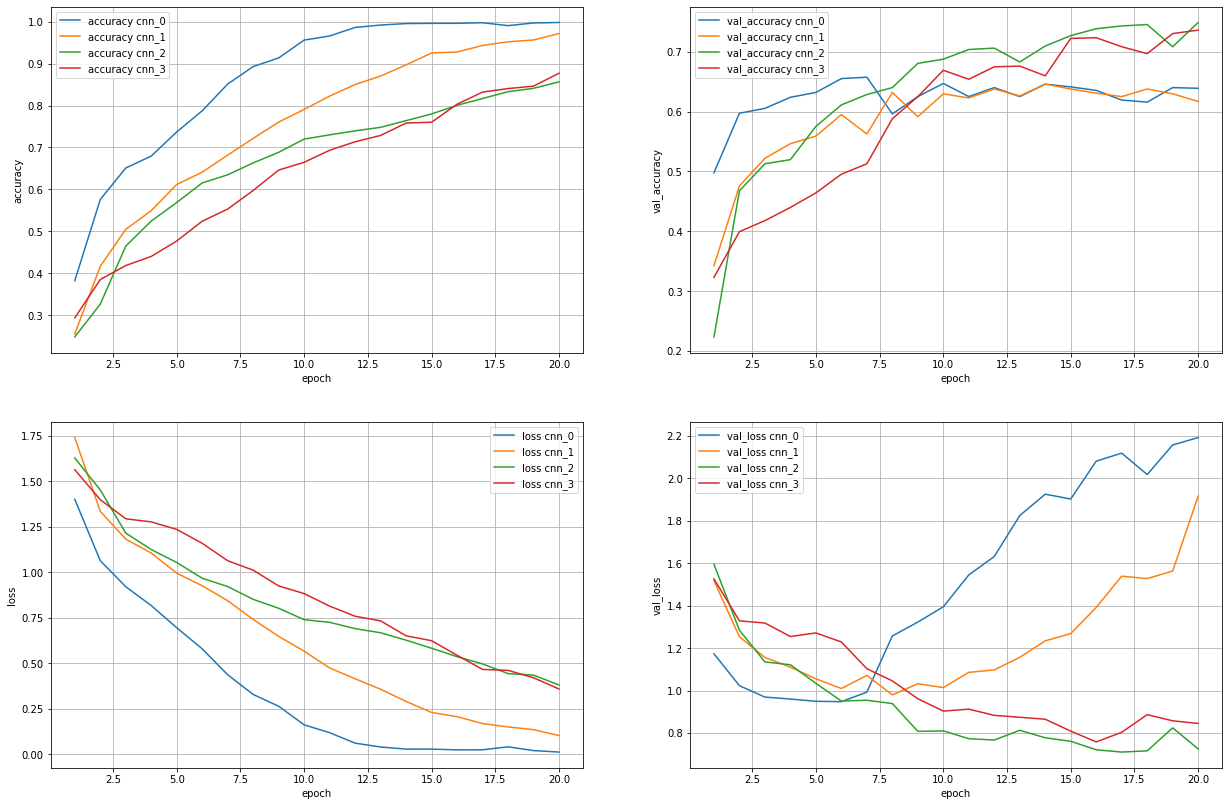

In [29]:
import matplotlib.pyplot as plt

epoch_range = list(range(1,21))

figure, axis = plt.subplots(2, 2, figsize=(21, 14))

plots_map = {
    'accuracy': axis[0, 0],
    'val_accuracy': axis[0, 1],
    'loss': axis[1, 0],
    'val_loss': axis[1, 1]
}

for attr, value in plots_map.items():
    for i, h in enumerate(cnn_histories):
        value.plot(epoch_range, h[attr], label=f'{attr} cnn_{i}')
    value.set_ylabel(attr)
    value.set_xlabel('epoch')
    value.legend()
    value.grid()

plt.show()